In [ ]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_dir =  '/content/drive/MyDrive/hotdog-nothotdog/'


def load_images_and_labels(category, label, data_type='train'):
    images = []
    labels = []
    path = os.path.join(base_dir, data_type, category)
    for file in os.listdir(path):
        img_path = os.path.join(path, file)
        img = load_img(img_path, target_size=(224, 224))  # 224x224 for MobileNetV2
        img = img_to_array(img)
        img = img / 255.0  # Normalize to [0, 1]
        images.append(img)
        if data_type == 'train':  # Only add labels for training data
            labels.append(label)
    return images, labels

In [ ]:
# Load all training images
hotdog_images, hotdog_labels = load_images_and_labels('hotdog', 1)
nothotdog_images, nothotdog_labels = load_images_and_labels('nothotdog', 0)

# Combine and shuffle
train_images = np.array(hotdog_images + nothotdog_images)
train_labels = np.array(hotdog_labels + nothotdog_labels)

# Use train_test_split to create the validation data
train_images, valid_images, train_labels, valid_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42)

# Load and configure the MobileNetV2 model for fine-tuning
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze layers

Epoch 1/50
107/107 [==============================] - 9s 62ms/step - loss: 0.3038 - accuracy: 0.8744 - val_loss: 0.2376 - val_accuracy: 0.9058
Epoch 2/50
107/107 [==============================] - 5s 50ms/step - loss: 0.2113 - accuracy: 0.9148 - val_loss: 0.2211 - val_accuracy: 0.9011
Epoch 3/50
107/107 [==============================] - 5s 50ms/step - loss: 0.2110 - accuracy: 0.9119 - val_loss: 0.2127 - val_accuracy: 0.9105
Epoch 4/50
107/107 [==============================] - 5s 50ms/step - loss: 0.1996 - accuracy: 0.9178 - val_loss: 0.2301 - val_accuracy: 0.9164
Epoch 5/50
107/107 [==============================] - 5s 50ms/step - loss: 0.1600 - accuracy: 0.9428 - val_loss: 0.2277 - val_accuracy: 0.9282
Epoch 6/50
107/107 [==============================] - 5s 49ms/step - loss: 0.1325 - accuracy: 0.9461 - val_loss: 0.2536 - val_accuracy: 0.9164
Epoch 7/50
107/107 [==============================] - 5s 49ms/step - loss: 0.1253 - accuracy: 0.9508 - val_loss: 0.2486 - val_accuracy: 0.9152

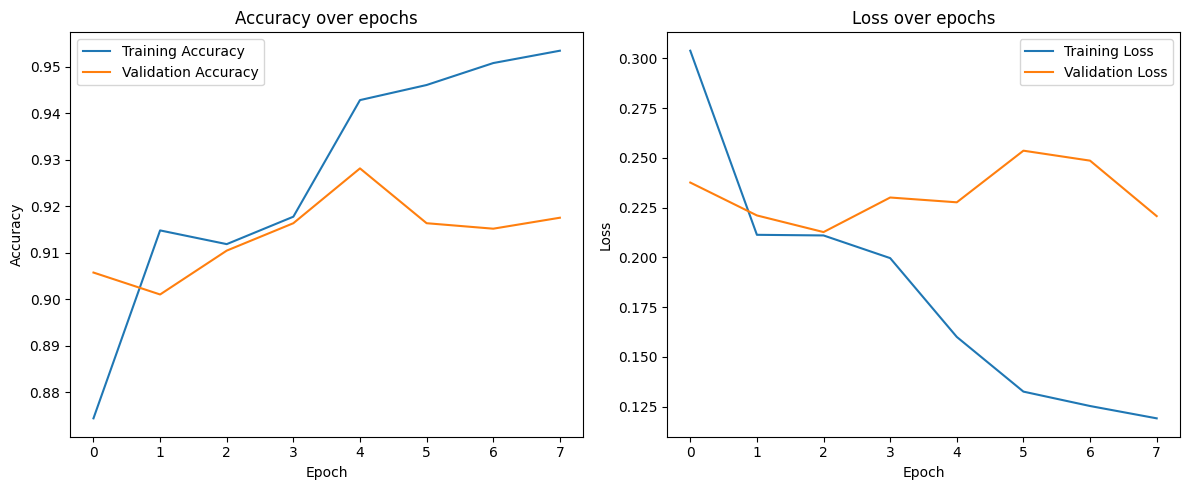

13/13 [==============================] - 1s 41ms/step


In [ ]:


# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Train the model
history = model.fit(train_images, train_labels, epochs=50, batch_size=32,
                    validation_data=(valid_images, valid_labels),
                    callbacks=[early_stopping])

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Prepare the test data
test_hotdog_images, _ = load_images_and_labels('hotdog', None, 'test')
test_nothotdog_images, _ = load_images_and_labels('nothotdog', None, 'test')
test_images = np.array(test_hotdog_images + test_nothotdog_images)
test_images_cnn = test_images.reshape((-1, 224, 224, 3))

# Predict on the test set
test_predictions = model.predict(test_images_cnn)
test_predicted_labels = (test_predictions > 0.5).astype(int).reshape(-1)



In [ ]:
#save model
import pickle
filename = "/content/drive/MyDrive/hotdog-nothotdog/updated_mobilenet.sav"
with open('model.sav', 'wb') as f:
    pickle.dump(model, f)


# New section